In [1]:

import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import stats
import pickle as pk
import tmEMD as temd


In [2]:
plt.style.use('Solarize_Light2')

### Dummy signal example

In [9]:
# Load dummy signal
X, signals, signal_colors, sample_rate = temd.get_figure_1()

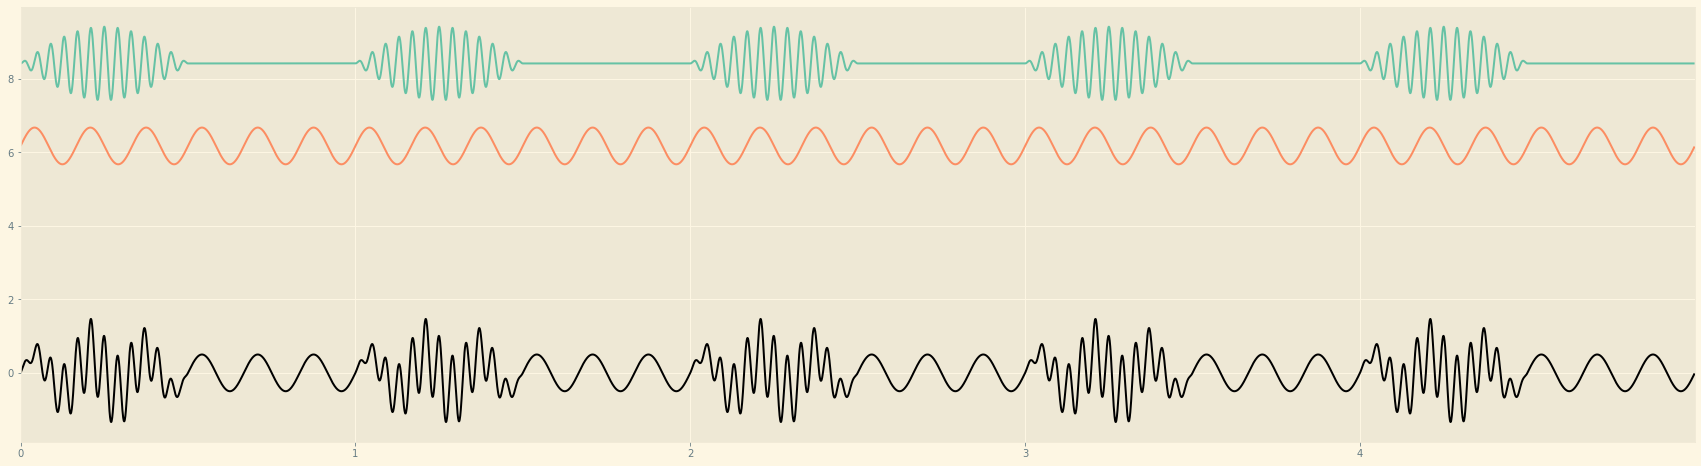

In [11]:
# Plot the dummy signal, which is contructed
plt.figure(figsize=(30,8))
temd.plot_emd(signals, sample_rate, X=X, spaceFactor=0.8, imfs_shift=12, lw_imfs=2, lw_X=2, imf_cols=signal_colors)

In [16]:
# Run tmEMD for a single mask frequency - see the agrgument f_set
Xs = [X]
mixScore_func = temd.get_modeMixScore_corr
it_mask_freqs, it_mix_scores, it_adj_mix_scores, it_consistency_scores, it_is, optimised_mask_freqs, converged = \
temd.run_tmEMD(Xs, sample_rate, mixScore_func=mixScore_func, max_imfs=2, n_per_it=100, top_n=5, nprocesses=4, f_set=[None, 0])

/home/data/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 25000 is greater than input length  = 6250, using nperseg = 6250
  .format(nperseg, input_length))


Solarize_Light2


/home/data/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 25000 is greater than input length  = 6250, using nperseg = 6250
  .format(nperseg, input_length))


0 1 2 Converged, averaging... 1 / 1
N_iter =  2


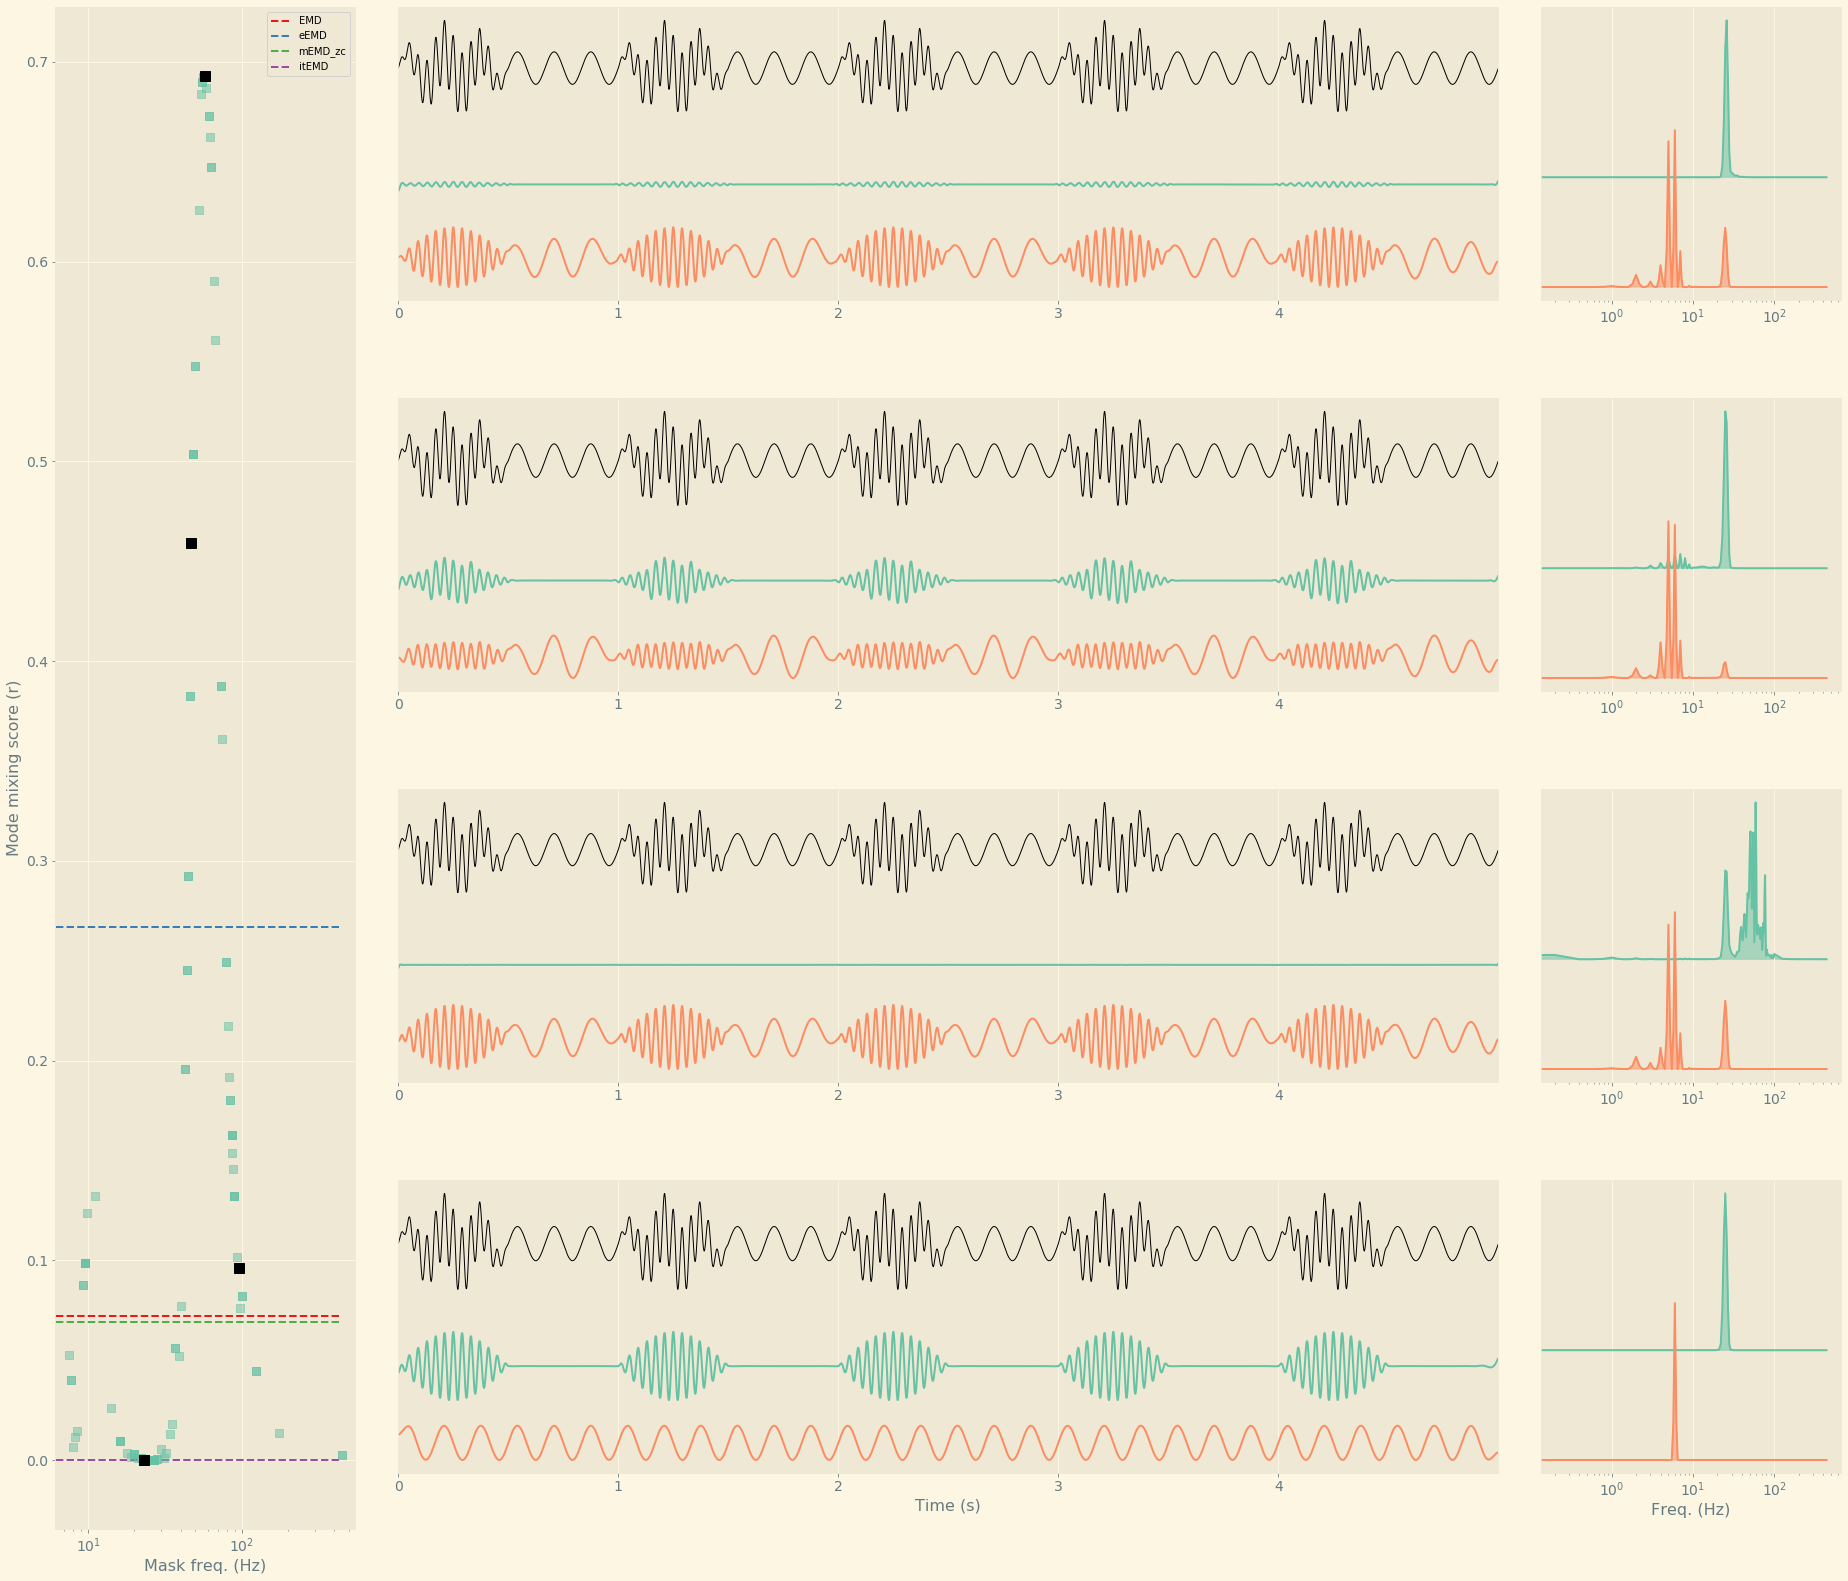

In [18]:
# Visualise tmEMD and compare mode mixing to EMD variants
variants = ['EMD', 'eEMD', 'mEMD_zc', 'itEMD']
temd.figplot_tmEMD(Xs, 0, it_mask_freqs, it_mix_scores, sample_rate, mixScore_func, spaceFactor=0.8, show_variants=True, variants=variants,
                   cmap='Set2', eg_percs=[100, 80, 50, 0], 
                   ms=8, ms_=10, large=True, show_egs=True, pad_egs=True)


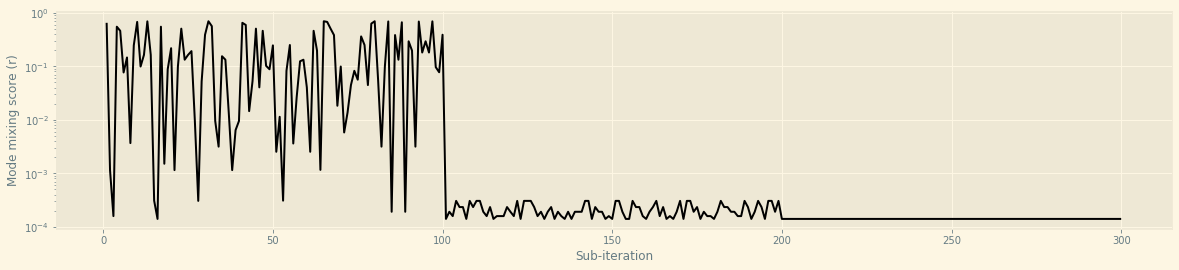

In [19]:
# Plot mixing scores as a function of tmEMD sub-iterations
_, label = mixScore_func(None, None, None, compute=False, return_label=True)

it_mix_scores_M = it_mix_scores.mean(axis=1)

plt.figure(figsize=(20, 4))
plt.plot(np.arange(it_mix_scores.shape[0])+1, it_mix_scores_M, color='k')
plt.xlabel('Sub-iteration')
plt.ylabel(label)
plt.yscale('log')


### Real data

In [20]:
rootFolder = '/.../.../.../example/' # change this path

sample_rate = 1250.
dataFolder = rootFolder+'data/'
outputFolder = rootFolder+'output/'
nX = 2 # number of animals to load and optimise

In [21]:
region = 'NAc' # brain region recorded
nSecs = 10 # up to 300 secs, for a faster runtime, make lower

# Load the local field potential recordings 
length = int(nSecs*sample_rate)
X_paths = [dataFolder+'ani_'+str(i+1)+'.'+region+'.lfp'+'.npy' for i in range(nX)]
Xs = [np.load(path)[:length] for path in X_paths]

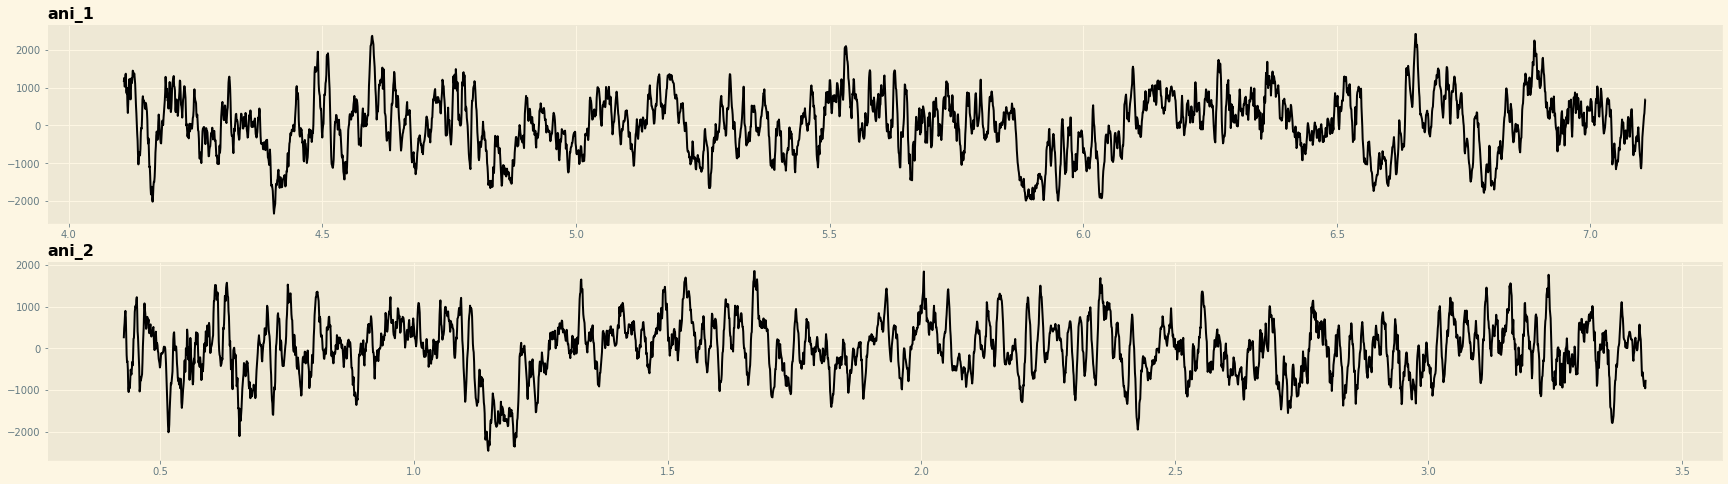

In [22]:

nSecs = 3
color='k'
w, h = 30, 4
#
nSamples = int(nSecs*sample_rate)

plt.figure(figsize=(w, h*nX))
for i, X in enumerate(Xs):
    
    plt.subplot(nX, 1, i+1)
    plt.title('ani_'+str(i+1), loc='left', fontweight='bold')

    st = np.random.choice(np.arange(len(X)-nSamples))
    en = st+ nSamples

    timeAx_secs = np.linspace(st/sample_rate, en/sample_rate, nSamples)

    plt.plot(timeAx_secs, X[st:en], color=color)


/home/data/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 25000 is greater than input length  = 12500, using nperseg = 12500
  .format(nperseg, input_length))


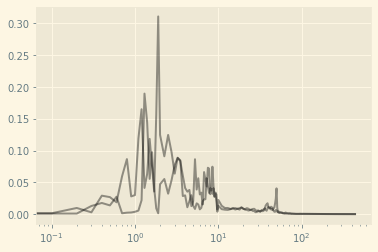

In [23]:
alpha, lw = 0.4, 2
for X in Xs:
    X = stats.zscore(X)
    f, p = temd.get_psd(X, sample_rate)
    plt.plot(f, p, color=color, alpha=alpha, lw=lw)
    plt.xscale('log')

In [24]:
# Run tmEMD on on the real data
nprocesses = 4

it_mask_freqs, it_mix_scores, it_adj_mix_scores, it_consistency_scores, it_is, optimised_mask_freqs, converged = \
temd.run_tmEMD(Xs, sample_rate, n_per_it=20, nprocesses=nprocesses, max_iterations=4, max_imfs=8)

/home/data/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 25000 is greater than input length  = 12500, using nperseg = 12500
  .format(nperseg, input_length))


First : plt.plot(it_mix_scores.mean(axis=1)) - if the scores look plateaued, there is likely no need to run further
Otherwise, consider:
 - increasing max_iterations, n_per_it
 - making max_iterations_b4_dim_red lower than max_iterations


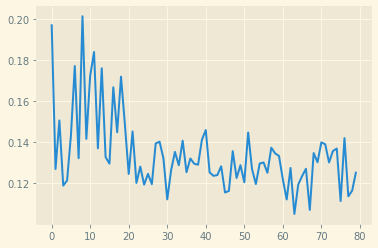

In [25]:
plt.plot(it_mix_scores.mean(axis=1))

Solarize_Light2


/home/data/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 25000 is greater than input length  = 12500, using nperseg = 12500
  .format(nperseg, input_length))


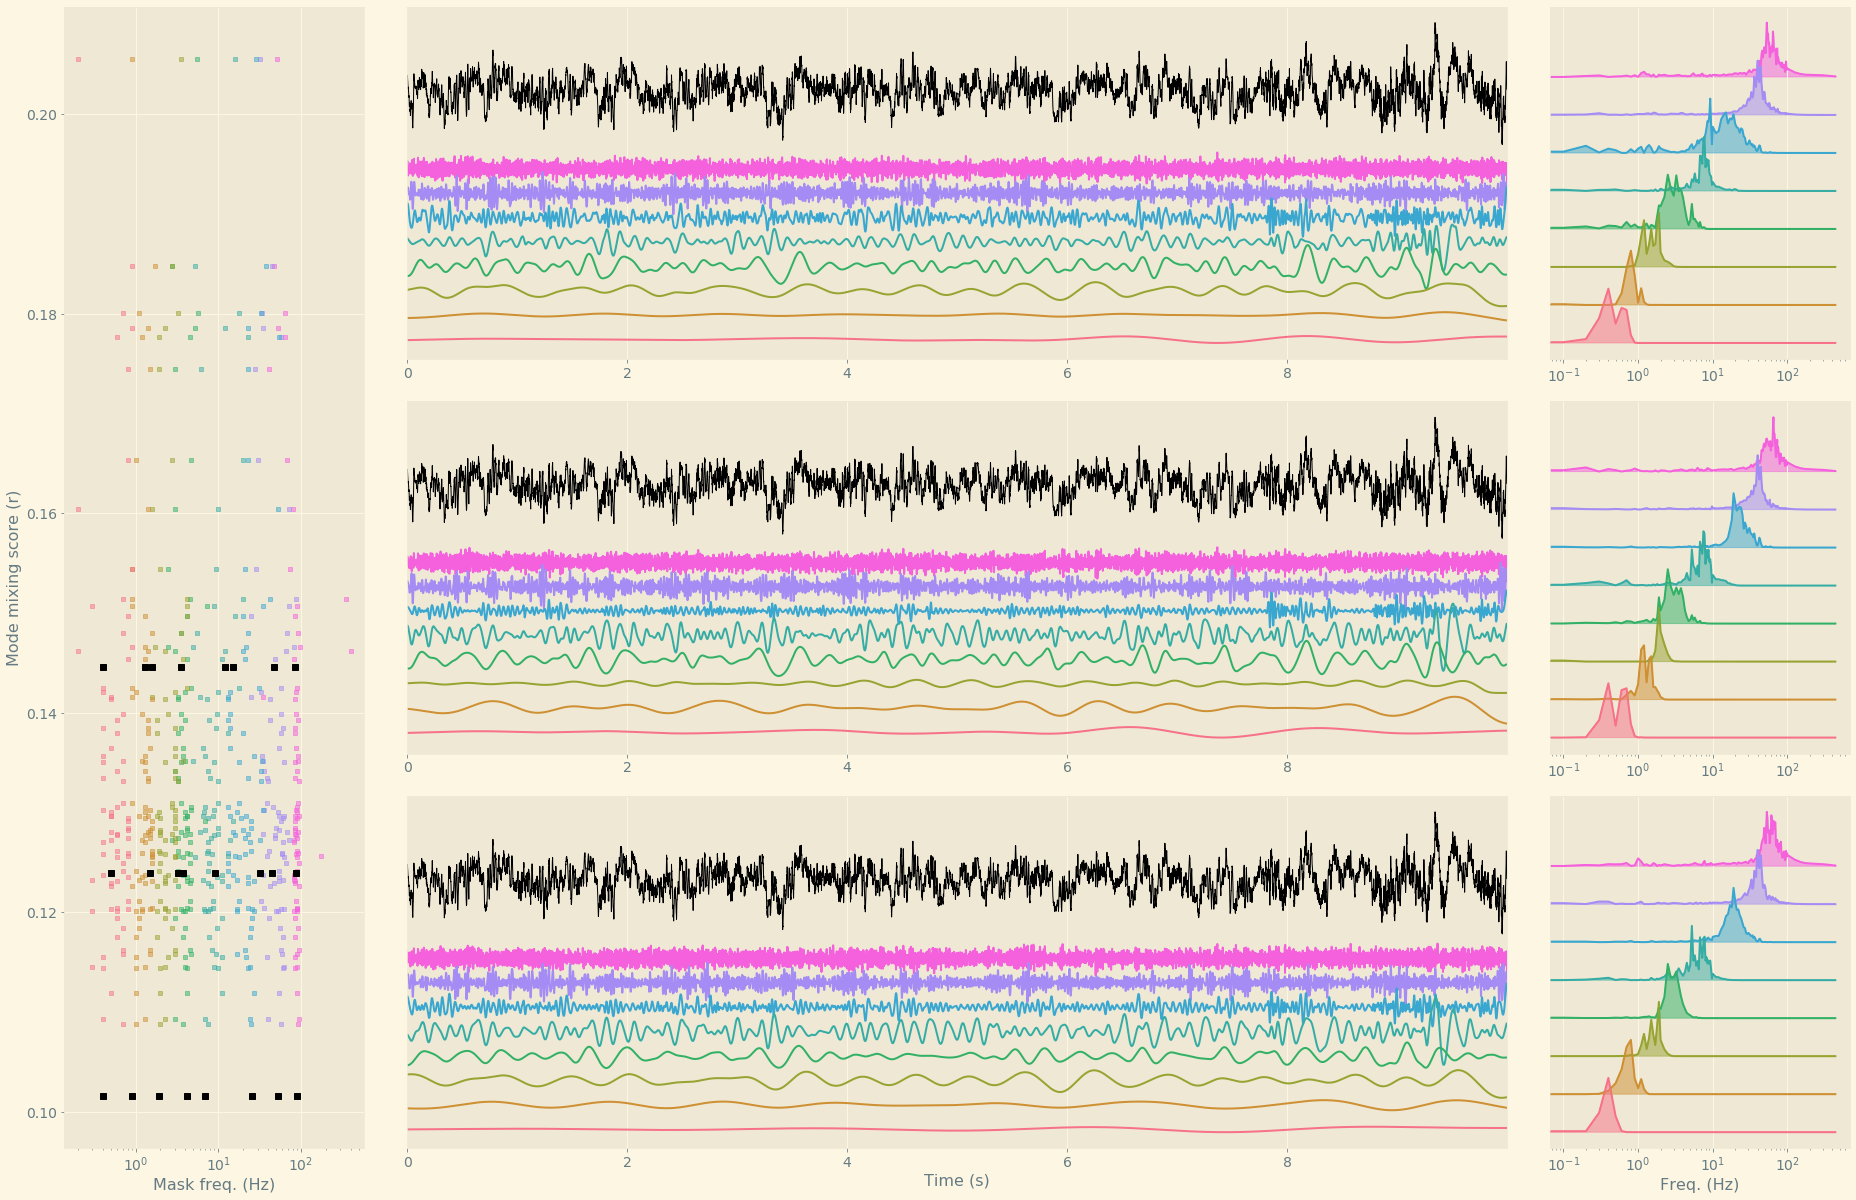

In [26]:
# Plot the tmEMD process
xi=0
temd.figplot_tmEMD(Xs, xi, it_mask_freqs, it_mix_scores, sample_rate, mixScore_func, show_variants=False, eg_percs=[0, 30, 80], opt2xi=True)

### Pre-run tmEMD outputs

In [27]:
region = 'NAc' # brain region recorded
mixScoreStr = 'psds' # 'psds' | 'pmsi'

# Load the local field potential recordings 
X_paths = [dataFolder+'ani_'+str(i+1)+'.'+region+'.lfp'+'.npy' for i in range(nX)]
Xs = [np.load(path) for path in X_paths]

# Get the corresponding mode mixing score function
mixScoreStr_funcs = {'psds' : temd.get_modeMixScore_imfPSDs, 
                     'pmsi' : temd.get_modeMixScore_pmsi}
mixScore_func = mixScoreStr_funcs[mixScoreStr]

file = 'eg_tmEMD_outputs.'+region+'_pre-eEMD_m_'+mixScoreStr+'.pkl'

with open(outputFolder+file, 'rb') as h:
    outputs = pk.load(h)
    
print(outputs.keys())

# Extract outputs
time_taken_secs, it_mask_freqs, it_mix_scores, it_adj_mix_scores, it_consistency_scores, it_is, optimised_mask_freqs, converged = \
[outputs[k] for k in ['time_taken_secs', 'it_mask_freqs', 'it_mix_scores', 'it_adj_mix_scores', 
                      'it_consistency_scores', 'it_is', 'optimised_mask_freqs', 'converged']]

dict_keys(['time_taken_secs', 'it_mask_freqs', 'it_mix_scores', 'it_adj_mix_scores', 'it_consistency_scores', 'it_is', 'optimised_mask_freqs', 'converged'])


Solarize_Light2
0 1 2 3 4 5 6 7 8 Converged, averaging... 1 / 1
N_iter =  8


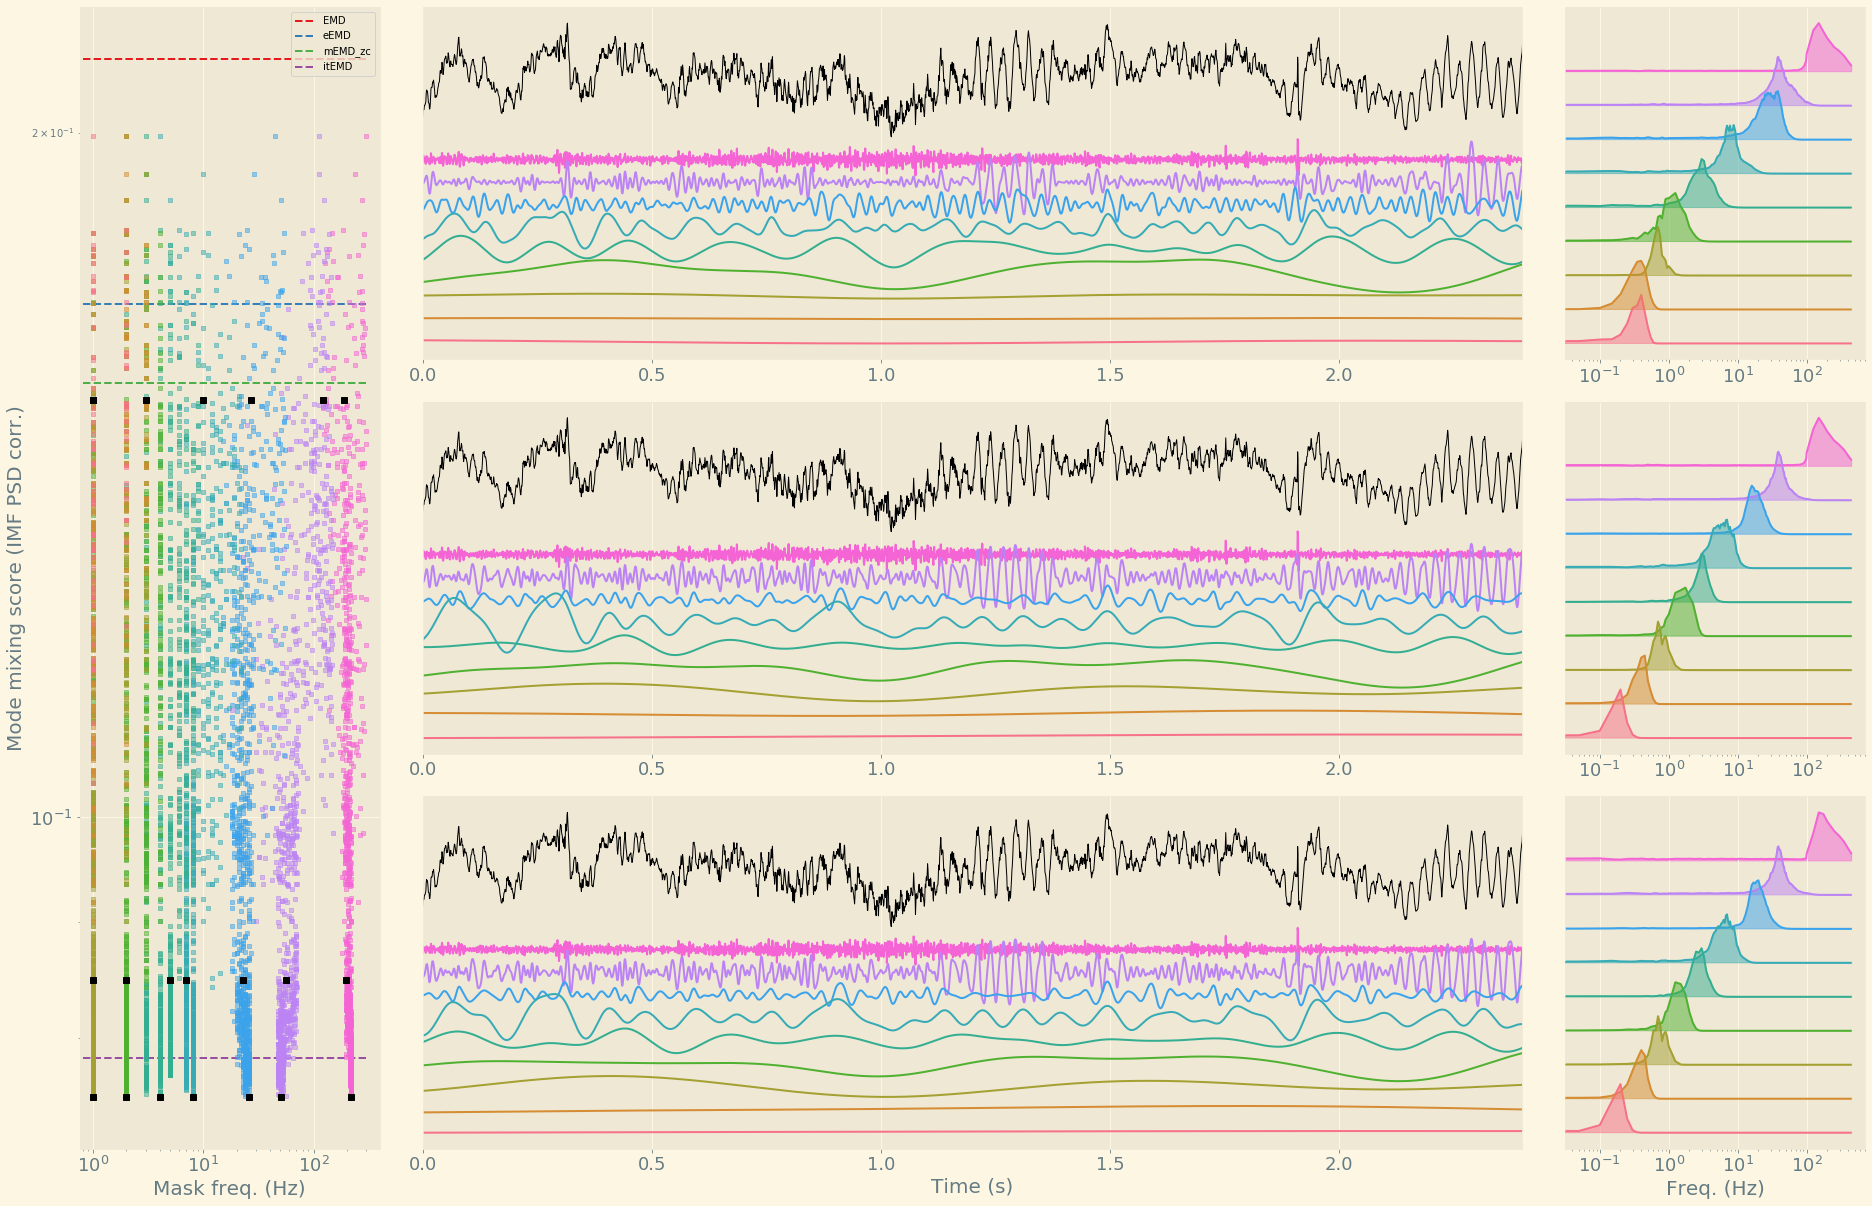

In [28]:
xi = 0
variants = ['EMD', 'eEMD', 'mEMD_zc', 'itEMD']
reload_functions()
temd.figplot_tmEMD(Xs, xi, it_mask_freqs, it_mix_scores, sample_rate, mixScore_func, log_mixScore=True, 
                   show_egs=True, opt2xi=True, eg_percs=[0, 40, 95], variants=variants, cmap='husl',
                   fontsize=20, 
                   show_variants=True, 
                   window=[22220, 25220])


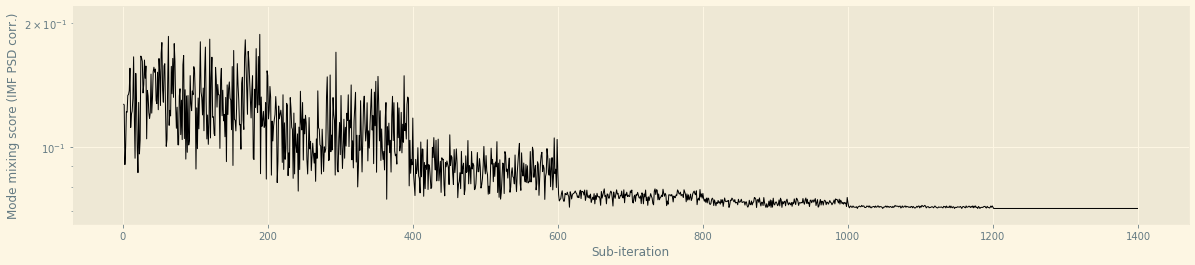

In [29]:
# Plot mixing scores as a function of tmEMD sub-iterations
_, label = mixScore_func(None, None, None, compute=False, return_label=True)

it_mix_scores_M = it_mix_scores.mean(axis=1)

plt.figure(figsize=(20, 4))
plt.plot(np.arange(it_mix_scores.shape[0])+1, it_mix_scores_M, color='k', lw=1)
plt.xlabel('Sub-iteration')
plt.ylim(0.065, 0.22)
plt.ylabel(label)
plt.yscale('log')


0 1 2 3 4 5 6 7 8 Converged, averaging... 1 / 1
N_iter =  8


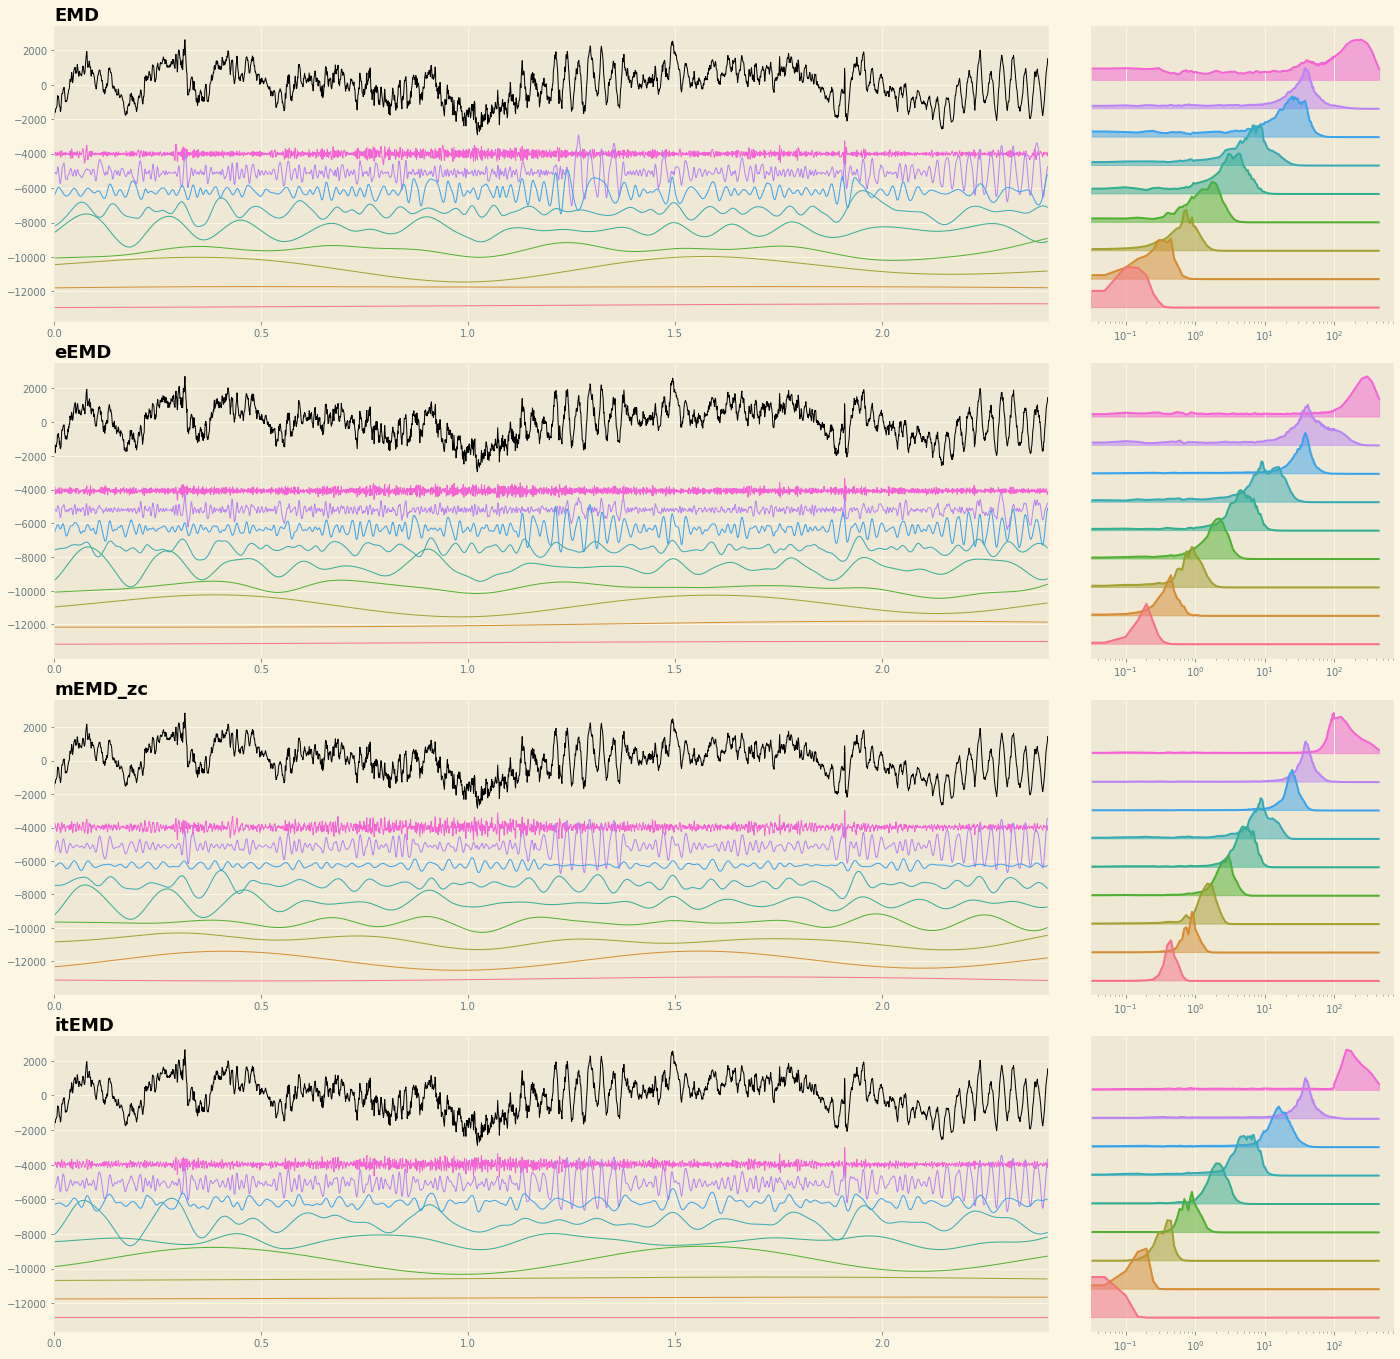

In [280]:
# Plot the IMFs yielded by the EMD variants
w_emd = 18
w_psd = 6
h = 6
facecolor=None

wTot = w_emd + w_psd
hTot = h * len(variants)

plt.figure(figsize=(wTot, hTot))
grid = plt.GridSpec(hTot, wTot, hspace=3, wspace=3)

currH = 0
for variant in variants:

    imfs = temd.run_emd(Xs[xi], sample_rate, variant)
    imf_cols = sns.color_palette('husl', imfs.shape[1])[::-1]
    plt.subplot(grid[currH:(currH+h), :w_emd], facecolor=facecolor)
    plt.title(variant, loc='left', fontweight='bold', fontsize=18)
    temd.plot_emd(imfs, sample_rate, window=[22220, 25220], imf_cols=imf_cols)
    
    plt.subplot(grid[currH:(currH+h), w_emd:], facecolor=facecolor)
    freqAx_psd, imfPSDs = temd.get_imfPSDs(imfs, sample_rate)
    temd.plot_imfPSDs(freqAx_psd, imfPSDs, imf_cols=imf_cols)
    
    currH += h
    

### Consideration of between-sample consistency

In [30]:
it_mix_scores_M, it_consistency_scores_M = [it_X.mean(axis=1) for it_X in [it_mix_scores, it_consistency_scores]]

label_mix, label_consistency = [f(None, None, None, compute=False, return_label=True)[1] for f in [mixScore_func, temd.get_consistencyScores]]

# Find the sub-iteration index which yeilds the best compromise for between-sample consistency 
index = np.column_stack([stats.rankdata(it_mix_scores_M), stats.rankdata(-it_consistency_scores_M)]).mean(axis=1).argmin()

0 1 2 3 4 5 6 7 8 Converged, averaging... 1 / 1
N_iter =  8
0 1 2 3 4 5 6 7 8 9 10 11 Converged, averaging... 1 / 1
N_iter =  11


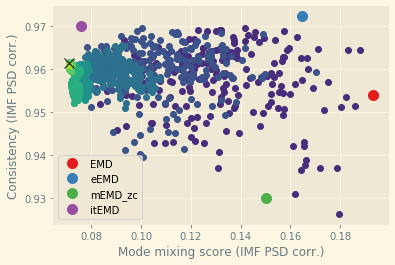

In [31]:
itiCols = sns.color_palette('viridis', len(np.unique(it_is)))
#plt.figure(figsize=(20, 6))

for iti, itiCol in enumerate(itiCols):
    inds = np.where(it_is == iti)[0]
    plt.plot(it_mix_scores_M[inds], it_consistency_scores_M[inds], 'o', color=itiCol)

variant_colors = sns.color_palette('Set1', len(variants))
for variant, color in zip(variants, variant_colors): 
    kScores = temd.get_modeMixScores_4_emd(Xs, sample_rate, variant, temd.get_psd, it_mask_freqs.shape[1])
    m, c = [kScores[k].mean() for k in [f(None, None, None, return_label=True, compute=False)[1] \
                                        for f in [mixScore_func, temd.get_consistencyScores]]]
    plt.plot(m, c, 'o', ms=10, color=color, label=variant)

plt.legend()
plt.plot(it_mix_scores_M[index], it_consistency_scores_M[index], 'x', ms=10, color='k')

for f1, f2 in zip([plt.xlabel, plt.ylabel], [mixScore_func, temd.get_consistencyScores]):
    f1(f2(None, None, None, return_label=True, compute=False)[1])



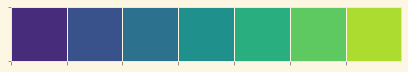

In [291]:
sns.palplot(itiCols)